# History and Data Analysis Collaboration System (LangGraph)

In [92]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_openai langchain_community langchain_core tavily-python wikipedia

In [93]:
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv

# Cargamos las variables de entorno
load_dotenv()

# Creamos la instancia base para los agentes
llm = ChatOpenAI(model="gpt-4o", temperature=0)

In [94]:
# Este prompt es el base para todos los agentes que vimos en el codigo anterior
agent_base_prompt = """

You are {name}, a {role}. Your skills include: {skills}. Respond to the task based on your role and skills.

""".strip()

# agent_base_prompt

In [95]:
from typing import List
from typing_extensions import TypedDict
from pydantic import BaseModel, Field
from dataclasses import dataclass, field


@dataclass
class Agent:
    name: str = "Default Agent"
    role: str = "General Agent"
    skills: List[str] = field(default_factory=lambda: ["basic"])
    llm: object = None

    @property
    def prompt(self):
        return agent_base_prompt.format(name=self.name, role=self.role, skills=", ".join(self.skills))


@dataclass
class HistoryResearchAgent(Agent):
    def __post_init__(self):
        self.name = "Clio"
        self.role = "History Research Specialist"
        self.skills = ["deep knowledge of historical events",
                       "understanding of historical contexts", "identifying historical trends"]
        self.llm = llm

    @classmethod
    def provide_relevant_context_task(self, task: str):
        return f"""
            Provide relevant historical context and information for the following task: {task}
            """.strip()

    @classmethod
    def data_provision_using_json_schema_task(self, json_schema: str):
        return f"""
            ## Task            
            Based on the data needs identified by the following JSON schema, generate data strictly adhering to this structure: 

            ```json
            {json_schema}
            ```

            ## Request
            Provide the requested information by the JSON schema.
        """.strip()

    @classmethod
    def synthesis_task(self):
        return """
            ## Request
            Based on all the historical context, data, and analysis, provide a comprehensive answer to the original task.
        """.strip()


@dataclass
class DataAnalysisAgent(Agent):
    def __post_init__(self):
        self.name = "Data"
        self.role = "Data Analysis Expert"
        self.skills = ["interpreting numerical data",
                       "statistical analysis", "data visualization description"]
        self.llm = llm

    @classmethod
    def identify_data_needs_using_json_schema(self, original_task: str, historical_context: str):
        return f"""
            ## Original Task
            {original_task}

            ## Historical Context
            {historical_context}

            ## Request
            Based on the historical context, what specific data or statistical information would be helpful to answer the original question? Create a JSON schema describing the data needed.
        """.strip()

    @classmethod
    def analyze_data(self, original_task:str, historical_data: str):
        return f"""
            ## Original Task           
            {original_task}

            ## Historical Data
            ```json
            {historical_data}
            ```
            ## Request
            Analyze the historical data provided and describe any trends or insights relevant to the original task.
        """.strip()

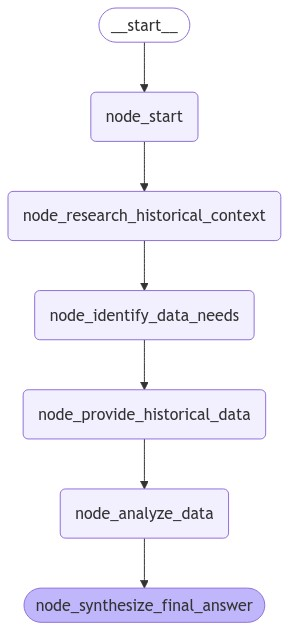

In [99]:
from IPython.display import Image, display
from langgraph.graph import START, END, StateGraph, MessagesState
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

class OverallState(MessagesState):
    history_research_agent: HistoryResearchAgent
    data_analysis_agent: DataAnalysisAgent
    original_task: str
    
def node_start(state: OverallState):
    return {
        "history_research_agent": HistoryResearchAgent(),
        "data_analysis_agent": DataAnalysisAgent(),
        "original_task": state["messages"][0].content
    }

def node_research_historical_context(state: OverallState):
    agent = state["history_research_agent"]
    agent_promt = agent.prompt

    task_prompt = agent.provide_relevant_context_task(state["original_task"])

    response = agent.llm.invoke([SystemMessage(content=agent_promt)] + [AIMessage(content=task_prompt)])

    return {
        "messages": response
    }

def node_identify_data_needs(state: OverallState):
    agent = state["data_analysis_agent"]
    agent_promt = agent.prompt

    historical_context = state["messages"][-1].content
    task_prompt = agent.identify_data_needs_using_json_schema(state["original_task"], historical_context)

    response = agent.llm.invoke([SystemMessage(content=agent_promt)] + [AIMessage(content=task_prompt)])

    return {
        "messages": response
    }

def node_provide_historical_data(state: OverallState):
    agent = state["history_research_agent"]
    agent_promt = agent.prompt

    data_needs = state["messages"][-1].content
    task_prompt = agent.data_provision_using_json_schema_task(data_needs)

    response = agent.llm.invoke([SystemMessage(content=agent_promt)] + [AIMessage(content=task_prompt)])

    return {
        "messages": response
    }

def node_analyze_data(state: OverallState):
    agent = state["data_analysis_agent"]
    agent_promt = agent.prompt

    analysis_result = state["messages"][-1].content
    task_prompt = agent.analyze_data(state["original_task"], analysis_result)

    response = agent.llm.invoke([SystemMessage(content=agent_promt)] + [AIMessage(content=task_prompt)])

    return {
        "messages": response
    }


def node_synthesize_final_answer(state: OverallState):
    agent = state["history_research_agent"]
    agent_promt = agent.prompt

    task_prompt = agent.synthesis_task()
    
    response = agent.llm.invoke([SystemMessage(content=agent_promt)] + state["messages"] + [AIMessage(content=task_prompt)])
    
    return {
        "messages": response
    }
    

builder = StateGraph(OverallState)

steps = [
    node_start,
    node_research_historical_context,
    node_identify_data_needs,
    node_provide_historical_data,
    node_analyze_data,
    node_synthesize_final_answer
]

for step in steps:
    builder.add_node(step.__name__, step)


builder.add_edge(START, "node_start")
for i in range(len(steps) - 1):
    builder.add_edge(steps[i].__name__, steps[i+1].__name__)

graph = builder.compile()

display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [101]:
import random
import string

thread_id = ''.join(random.choices(string.ascii_letters + string.digits, k=6))

config = {
    "configurable": {
        "thread_id": thread_id
    }
}

initial_state = {
    "messages": [HumanMessage(content="Cuantas personas murieron por covid-19 en Argentina desde el inicial hasta el fin de la pandemia?")],
}

messages = graph.invoke(initial_state, config=config)

print(messages['messages'][-1].pretty_print())

# for m in messages['messages']:
#     m.pretty_print()

================================== Ai Message ==================================

Desde el inicio de la pandemia de COVID-19 hasta octubre de 2023, Argentina ha registrado un total de aproximadamente 130,000 muertes relacionadas con el virus. Este número refleja el impacto acumulado de la pandemia en el país. A medida que la pandemia avanzó, Argentina implementó diversas medidas de salud pública, como cuarentenas, restricciones de viaje y campañas de vacunación, que han contribuido a controlar la propagación del virus.

En los últimos tiempos, el número de nuevas muertes diarias ha disminuido significativamente, con solo 5 nuevas muertes reportadas el 1 de octubre de 2023. Esta tendencia positiva sugiere que la situación está bajo mejor control, posiblemente debido a la efectividad de las medidas de salud pública y la vacunación.

Los datos provienen del Ministerio de Salud de Argentina, una fuente confiable, y se han mantenido consistentes en sus criterios de reporte, lo que asegura l